In [1]:
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## function to make heatmap
def plot_heatmaps(data_dict, sim, cmap=None, normalized=True):
    indx = "indx_conf"
    score = "conf_change"
    score_sign = "+"
    
#     indx = "indx"
#     score = "loss"
#     score_sign = "-"
    
    ## Calling cards signal
    data = np.zeros((10,160))
    for i in range(10):
        for j in range(20):
            if score_sign == "+":
                data[i,data_dict["cc_"+sim][str(i)][indx][j]] = data_dict["cc_"+sim][str(i)][score][j]
            elif score_sign == "-" and data_dict["cc_"+sim][str(i)][score][j] < 0:
                data[i,data_dict["cc_"+sim][str(i)][indx][j]] = data_dict["cc_"+sim][str(i)][score][j]
    ## normalize 
    if normalized:
        if score_sign == "+":
            data_norm = data / np.max(data,axis=1).reshape(-1,1)
        elif score_sign == "-":    
            data_norm = data / (-np.min(data,axis=1).reshape(-1,1))
    else:
        data_norm = data
                
    ## plot
    plt.figure(num=None, figsize=(8,3), dpi=150)
    ax = sns.heatmap(data_norm, cmap=cmap)
    ax.set_xlabel("Dist of CC signal to ATG")
    ax.set_ylabel("CV fold")
    ax.set_xticklabels(800-25*np.arange(160), rotation=60, ha='right')
    plt.show()
    
    ## Histone marks
    data = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            if score_sign == "+":
                data[i,data_dict["hm_"+sim][str(i)][indx][j]] = data_dict["hm_"+sim][str(i)][score][j]
            elif score_sign == "-" and data_dict["hm_"+sim][str(i)][score][j] < 0:
                data[i,data_dict["hm_"+sim][str(i)][indx][j]] = data_dict["hm_"+sim][str(i)][score][j]
    ## normalize 
    if normalized:
        if score_sign == "+":
            data_norm = data / np.max(data,axis=1).reshape(-1,1)
        elif score_sign == "-":    
            data_norm = data / (-np.min(data,axis=1).reshape(-1,1))
    else:
        data_norm = data
    ## plot
    plt.figure(num=None, figsize=(4,3), dpi=150)
    ax = sns.heatmap(data_norm, cmap=cmap)
    ax.set_xlabel("Histone marks")
    ax.set_ylabel("CV fold")
    hms = ['H3K27ac_prom_-1','H3K36me3_prom_-1',
            'H3K4me3_prom_-1','H3K79me_prom_-1',
            'H4K16ac_prom_-1','H3K27ac_body',
            'H3K36me3_body','H3K4me3_body',
            'H3K79me_body','H4K16ac_body']
    ax.set_xticklabels(hms, rotation=60, ha='right')
    plt.show()

In [13]:
def plot_feature_signals(file_feature, file_label, plot_hm=True):
    feat = np.loadtxt(file_feature, dtype=float)
    label = np.loadtxt(file_label, dtype=int)

    cc2plot = np.vstack(((np.sum(feat[label==1,:160],axis=0)/len(feat[label==1,]))[np.newaxis], 
                         (np.sum(feat[label==0,:160],axis=0)/len(feat[label==0,]))[np.newaxis]))
    hm2plot = np.vstack(((np.sum(feat[label==1,160:],axis=0)/len(feat[label==1,]))[np.newaxis], 
                         (np.sum(feat[label==0,160:],axis=0)/len(feat[label==0,]))[np.newaxis]))

#     cc2plot = np.vstack((np.sum(feat[label==1,:160],axis=0)[np.newaxis], 
#                          np.sum(feat[label==0,:160],axis=0)[np.newaxis]))
#     hm2plot = np.vstack((np.sum(feat[label==1,160:],axis=0)[np.newaxis], 
#                          np.sum(feat[label==0,160:],axis=0)[np.newaxis]))

    cc_ratio = np.log2(cc2plot[0,] / cc2plot[1,])
    hm_ratio = np.log2(hm2plot[0,] / hm2plot[1,])
    
    ## plot heatmap 
    plt.figure(num=None, figsize=(8,1), dpi=150)
    ax = sns.heatmap(cc2plot, cmap="YlOrRd")
    ax.set_xticklabels(800-25*np.arange(160), rotation=60, ha='right')
    ax.set_yticklabels(["Responsive", "Non-responsive"], rotation=0)
    plt.show()
    
    fig,ax = plt.subplots(num=None, figsize=(6,1), dpi=150)
    ax.plot(cc_ratio)
    ax.plot([0]*len(cc_ratio))
    ax.set_ylabel("Responsive / non-responsive")
    ax.set_xticklabels(900-100*np.arange(10), rotation=60, ha='right')
    plt.show()
    
    if plot_hm:
        plt.figure(num=None, figsize=(4,1), dpi=150)
        ax = sns.heatmap(hm2plot, cmap="YlOrRd")
        hms = ['H3K27ac_prom_-1','H3K36me3_prom_-1',
                'H3K4me3_prom_-1','H3K79me_prom_-1',
                'H4K16ac_prom_-1','H3K27ac_body',
                'H3K36me3_body','H3K4me3_body',
                'H3K79me_body','H4K16ac_body']
        ax.set_xticklabels(hms, rotation=60, ha='right')
        ax.set_yticklabels(["Responsive", "Non-responsive"], rotation=0)
        plt.show()

        fig,ax = plt.subplots(num=None, figsize=(3,1), dpi=150)
        ax.plot(hm_ratio)
        ax.plot([0]*len(hm_ratio))
        ax.set_ylabel("Responsive / non-responsive")
        ax.set_xticks(range(10))
        ax.set_xticklabels(hms, rotation=60, ha='right')
        plt.show()

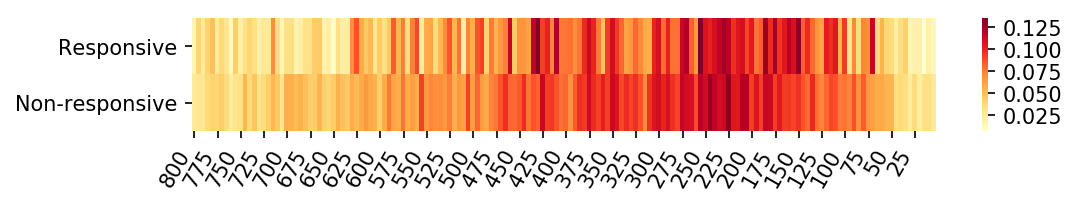

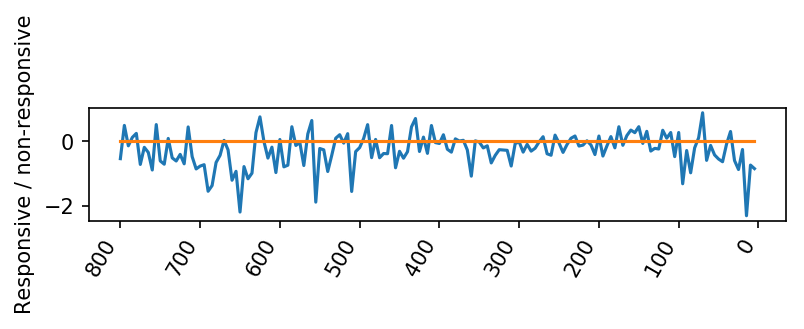

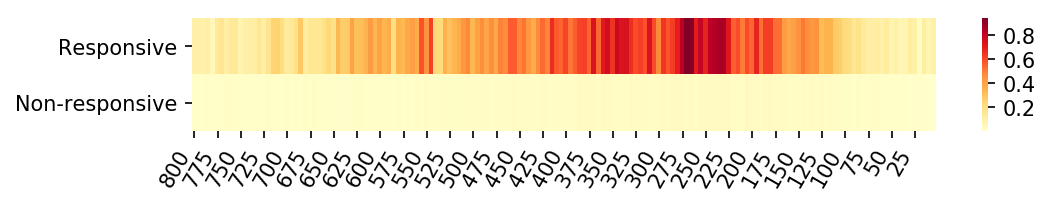

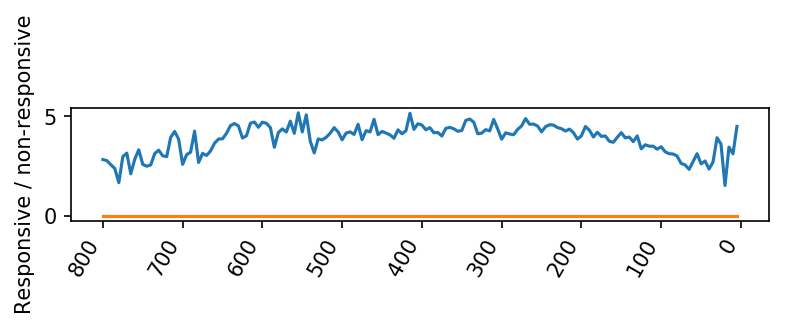

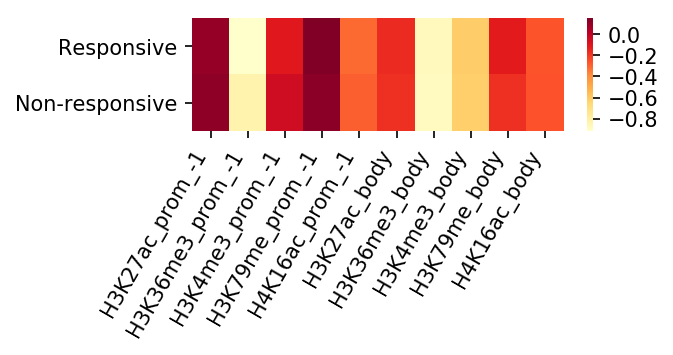

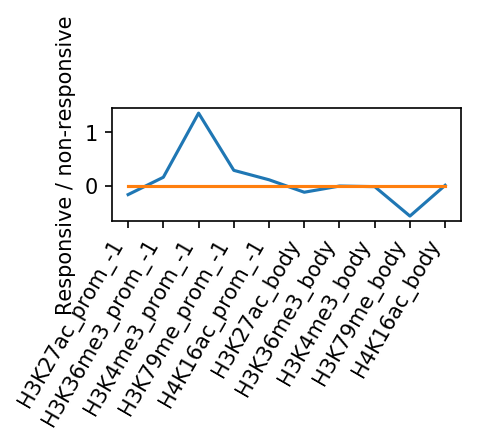

In [14]:
plot_feature_signals("../output4/multiTF_bg_feature_matrix.txt", "../output4/multiTF_label_matrix.txt", False)
plot_feature_signals("../output4/multiTF_feature_matrix.txt", "../output4/multiTF_label_matrix.txt")

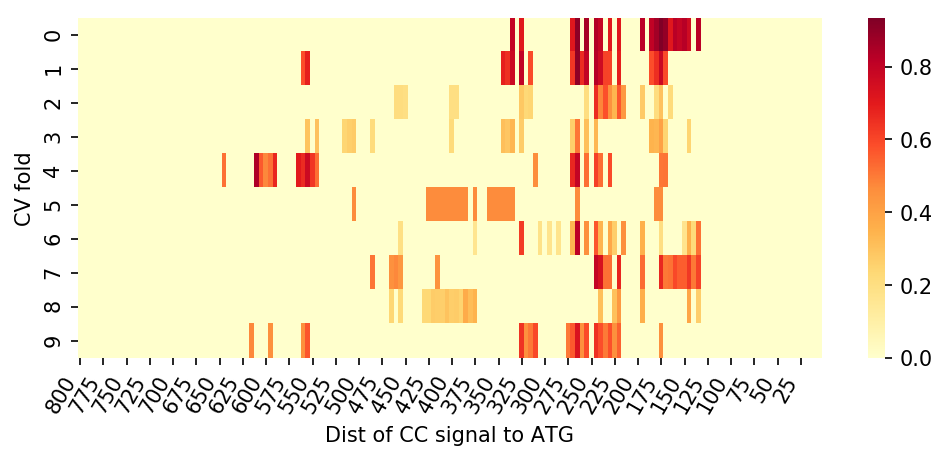

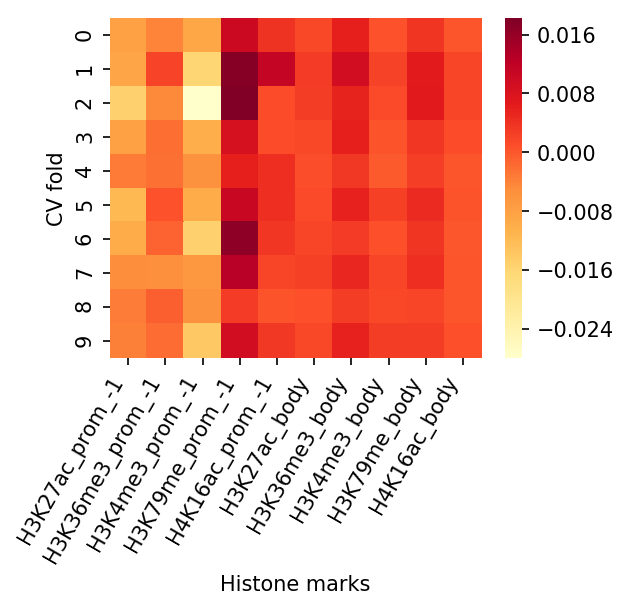

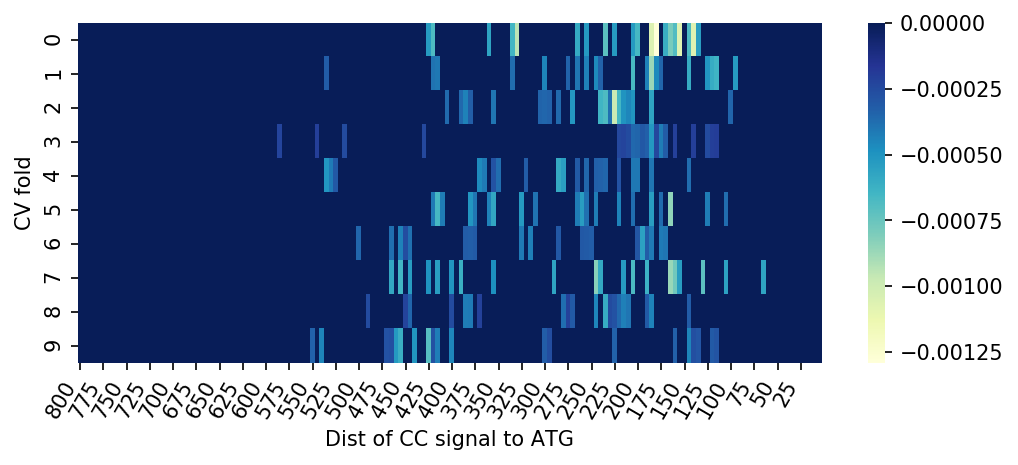

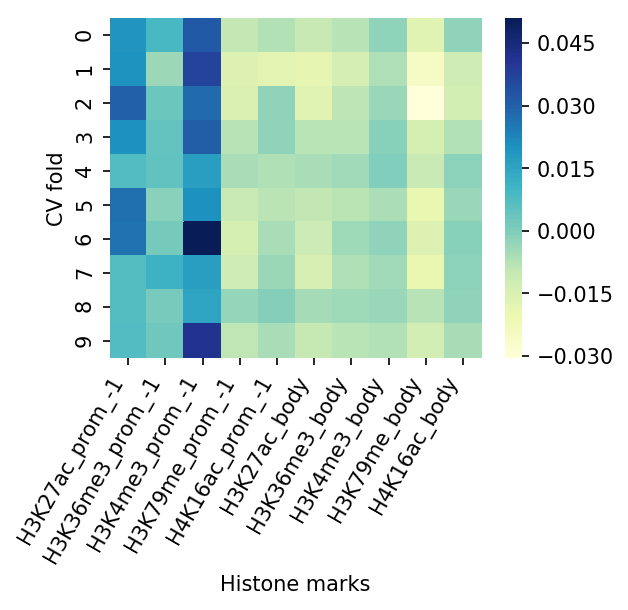

In [27]:
## load CNN data
with open("../output4/multiTF_feature_ranking.cnn.json", "r") as fp:
    rf_dict = json.load(fp)
normalized = False
plot_heatmaps(rf_dict, "high", "YlOrRd", normalized)
plot_heatmaps(rf_dict, "low", "YlGnBu", normalized)

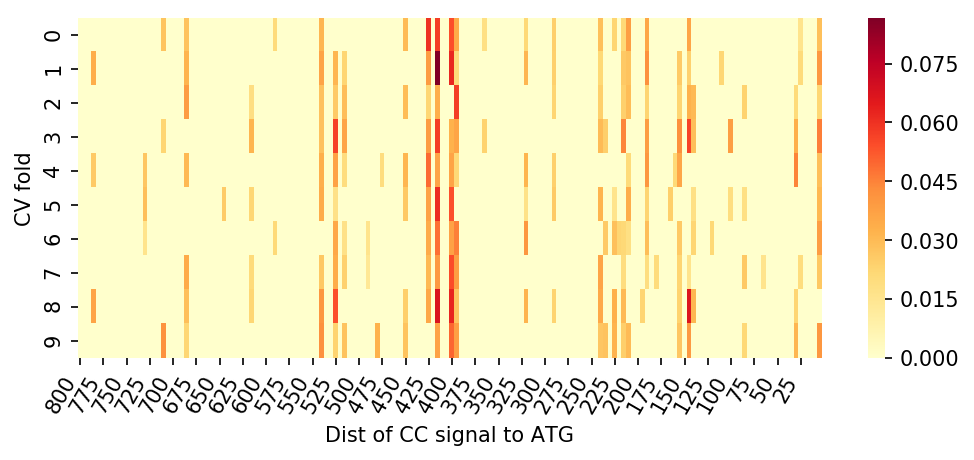

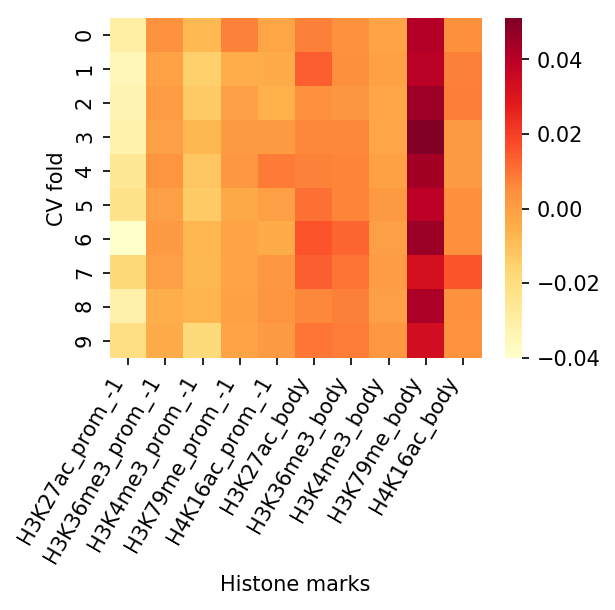

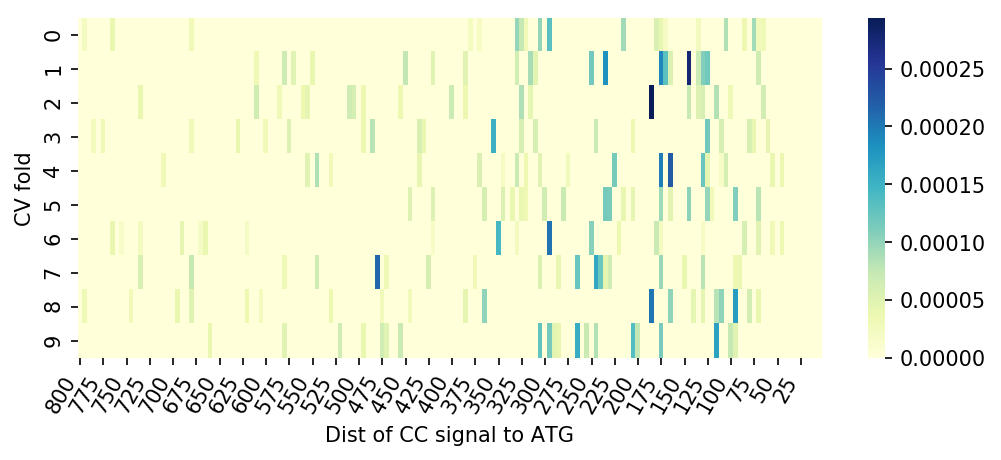

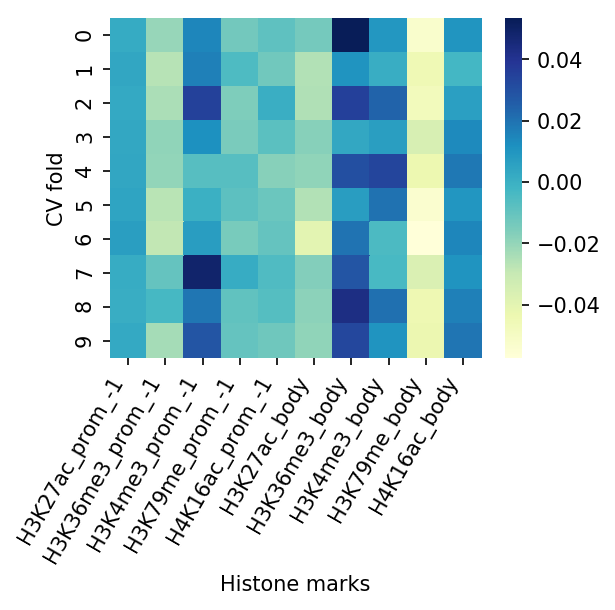

In [28]:
## load RF data
with open("../output4/multiTF_feature_ranking.rf.json", "r") as fp:
    rf_dict = json.load(fp)
normalized = False
plot_heatmaps(rf_dict, "high", "YlOrRd", normalized)
plot_heatmaps(rf_dict, "low", "YlGnBu", normalized)

In [22]:
## function to make heatmap
def plot_coarse_heatmaps(data_dict, sim, cmap=None, normalized=True):
    indx = "indx_conf"
    score = "conf_change"
    score_sign = "+"
    
#     indx = "indx"
#     score = "loss"
#     score_sign = "-"
    
    ## Calling cards signal
    data = np.zeros((10,4))
    for i in range(10):
        for j in range(4):
            if score_sign == "+":
                data[i,data_dict["cc_"+sim][str(i)][indx][j]] = data_dict["cc_"+sim][str(i)][score][j]
            elif score_sign == "-" and data_dict["cc_"+sim][str(i)][score][j] < 0:
                data[i,data_dict["cc_"+sim][str(i)][indx][j]] = data_dict["cc_"+sim][str(i)][score][j]
    ## normalize 
    if normalized:
        if score_sign == "+":
            data_norm = data / np.max(data,axis=1).reshape(-1,1)
        elif score_sign == "-":    
            data_norm = data / (-np.min(data,axis=1).reshape(-1,1))
    else:
        data_norm = data
                
    ## plot
    plt.figure(num=None, figsize=(3,3), dpi=150)
    ax = sns.heatmap(data_norm, cmap=cmap)
    ax.set_xlabel("Dist of CC signal to ATG")
    ax.set_ylabel("CV fold")
    ax.set_xticklabels(["650-800bp","450-650bp","100-450bp","0-100bp"], rotation=60, ha='right')
    plt.show()
    
    ## Histone marks
    data = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            if score_sign == "+":
                data[i,data_dict["hm_"+sim][str(i)][indx][j]] = data_dict["hm_"+sim][str(i)][score][j]
            elif score_sign == "-" and data_dict["hm_"+sim][str(i)][score][j] < 0:
                data[i,data_dict["hm_"+sim][str(i)][indx][j]] = data_dict["hm_"+sim][str(i)][score][j]
    ## normalize 
    if normalized:
        if score_sign == "+":
            data_norm = data / np.max(data,axis=1).reshape(-1,1)
        elif score_sign == "-":    
            data_norm = data / (-np.min(data,axis=1).reshape(-1,1))
    else:
        data_norm = data
    ## plot
    plt.figure(num=None, figsize=(4,3), dpi=150)
    ax = sns.heatmap(data_norm, cmap=cmap)
    ax.set_xlabel("Histone marks")
    ax.set_ylabel("CV fold")
    hms = ['H3K27ac_prom_-1','H3K36me3_prom_-1',
            'H3K4me3_prom_-1','H3K79me_prom_-1',
            'H4K16ac_prom_-1','H3K27ac_body',
            'H3K36me3_body','H3K4me3_body',
            'H3K79me_body','H4K16ac_body']
    ax.set_xticklabels(hms, rotation=60, ha='right')
    plt.show()

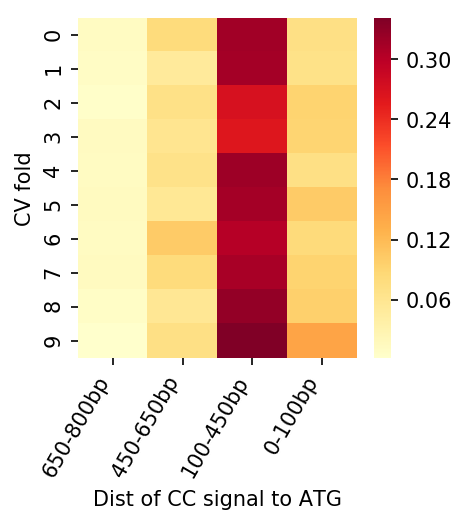

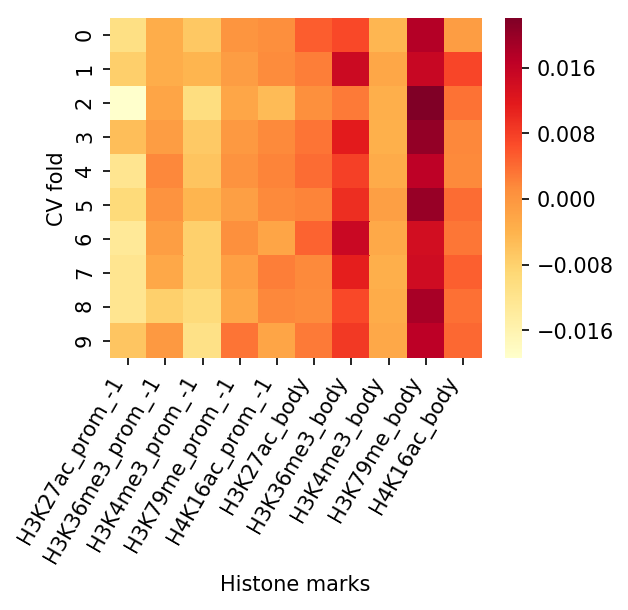

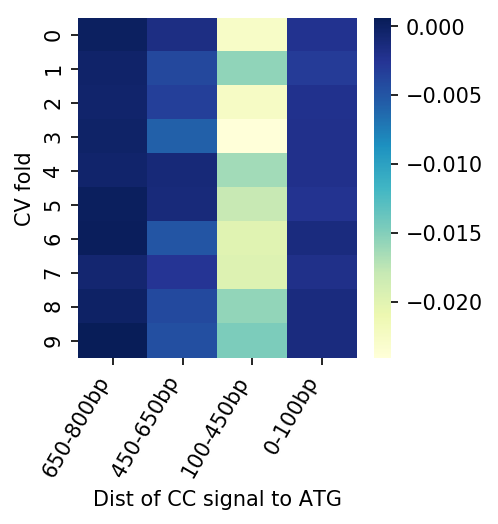

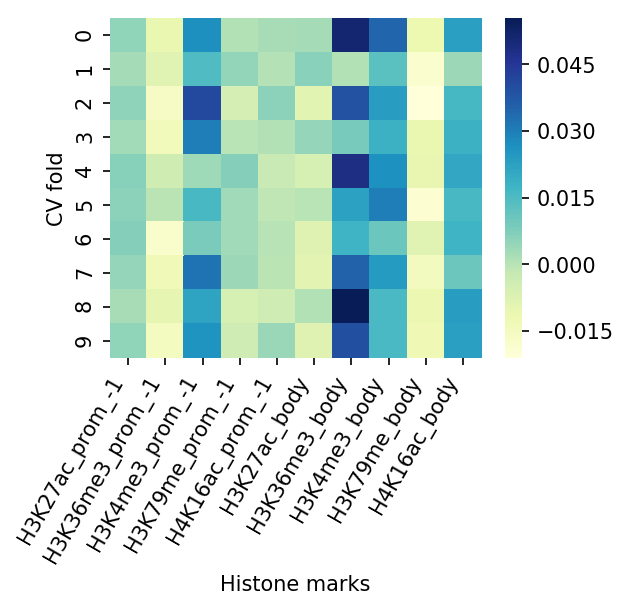

In [24]:
## load RF data
with open("../output4/multiTF_feature_ranking.rf_coarse.json", "r") as fp:
    rf_dict = json.load(fp)
normalized = False
plot_coarse_heatmaps(rf_dict, "high", "YlOrRd", normalized)
plot_coarse_heatmaps(rf_dict, "low", "YlGnBu", normalized)